In [114]:
import mxnet as mx
import numpy as np
from mxnet import nd, autograd, gluon
mx.random.seed(1)

In [116]:
data_ctx=mx.gpu()
model_ctx=mx.gpu()
ctx=mx.gpu()
num_output=5

In [117]:
train_data = mx.io.ImageRecordIter(
    path_imgrec="image_data_temp1_train.rec", 
    data_shape=(3,200,200),
    batch_size=32,
    scale=1/255,
    shuffle=1,
    rand_crop=True,
    rand_mirror=True
    
)

# 创建内部测试集iter
test_data = mx.io.ImageRecordIter(
    path_imgrec="image_data_temp1_test.rec",
    data_shape=(3,200,200),
    batch_size=32,
    scale=1/255,
    shuffle=1
    
)

DataBatch: data shapes: [(32, 3, 200, 200)] label shapes: [(32,)]


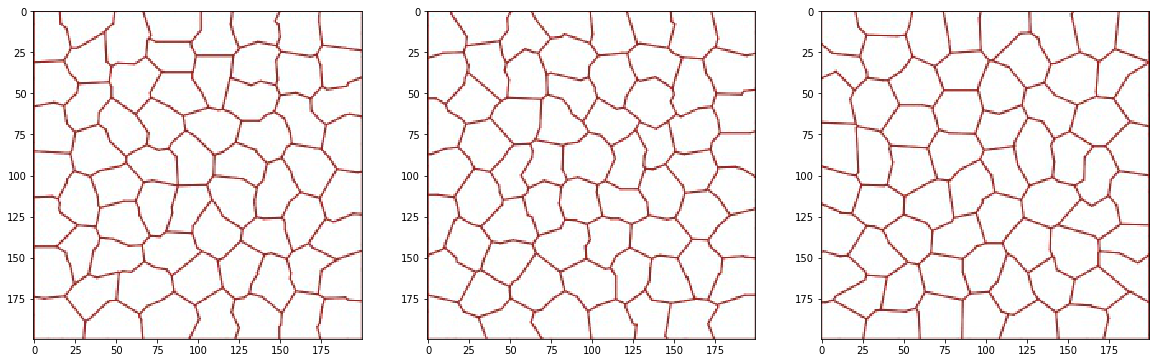

In [118]:
from matplotlib import pyplot as plt
train_data.reset()
batch = train_data.next() #
print(batch) 

data = batch.data[0]
fig=plt.figure(0,figsize=(20,20))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow((data[i]*255).asnumpy().astype(np.uint8).transpose((1,2,0)))
    
plt.show()

In [82]:
batch.label[0][1]


[6.]
<NDArray 1 @cpu_pinned(0)>

In [125]:
"""ResNets, implemented in Gluon."""
from __future__ import division

__all__ = ['ResNetV1', 'ResNetV2',
           'BasicBlockV1', 'BasicBlockV2',
           'BottleneckV1', 'BottleneckV2',
           'resnet18_v1', 'resnet34_v1', 'resnet50_v1', 'resnet101_v1', 'resnet152_v1',
           'resnet18_v2', 'resnet34_v2', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2',
           'get_resnet']

import os
from mxnet.gluon.block import HybridBlock
from mxnet.gluon import nn

# Helpers
def _conv3x3(channels, stride, in_channels):
    return nn.Conv2D(channels, kernel_size=3, strides=stride, padding=1,
                     use_bias=False, in_channels=in_channels)


# Blocks
class BasicBlockV1(HybridBlock):
    r"""BasicBlock V1 from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    This is used for ResNet V1 for 18, 34 layers.
    Parameters
    ----------
    channels : int
        Number of output channels.
    stride : int
        Stride size.
    downsample : bool, default False
        Whether to downsample the input.
    in_channels : int, default 0
        Number of input channels. Default is 0, to infer from the graph.
    """
    def __init__(self, channels, stride, downsample=False, in_channels=0, **kwargs):
        super(BasicBlockV1, self).__init__(**kwargs)
        self.body = nn.HybridSequential(prefix='')
        self.body.add(_conv3x3(channels, stride, in_channels))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(_conv3x3(channels, 1, channels))
        self.body.add(nn.BatchNorm())
        if downsample:
            self.downsample = nn.HybridSequential(prefix='')
            self.downsample.add(nn.Conv2D(channels, kernel_size=1, strides=stride,
                                          use_bias=False, in_channels=in_channels))
            self.downsample.add(nn.BatchNorm())
        else:
            self.downsample = None

    def hybrid_forward(self, F, x):
        residual = x

        x = self.body(x)

        if self.downsample:
            residual = self.downsample(residual)

        x = F.Activation(residual+x, act_type='relu')

        return x


class BottleneckV1(HybridBlock):
    r"""Bottleneck V1 from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    This is used for ResNet V1 for 50, 101, 152 layers.
    Parameters
    ----------
    channels : int
        Number of output channels.
    stride : int
        Stride size.
    downsample : bool, default False
        Whether to downsample the input.
    in_channels : int, default 0
        Number of input channels. Default is 0, to infer from the graph.
    """
    def __init__(self, channels, stride, downsample=False, in_channels=0, **kwargs):
        super(BottleneckV1, self).__init__(**kwargs)
        self.body = nn.HybridSequential(prefix='')
        self.body.add(nn.Conv2D(channels//4, kernel_size=1, strides=stride))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(_conv3x3(channels//4, 1, channels//4))
        self.body.add(nn.BatchNorm())
        self.body.add(nn.Activation('relu'))
        self.body.add(nn.Conv2D(channels, kernel_size=1, strides=1))
        self.body.add(nn.BatchNorm())
        if downsample:
            self.downsample = nn.HybridSequential(prefix='')
            self.downsample.add(nn.Conv2D(channels, kernel_size=1, strides=stride,
                                          use_bias=False, in_channels=in_channels))
            self.downsample.add(nn.BatchNorm())
        else:
            self.downsample = None

    def hybrid_forward(self, F, x):
        residual = x

        x = self.body(x)

        if self.downsample:
            residual = self.downsample(residual)

        x = F.Activation(x + residual, act_type='relu')
        return x


class BasicBlockV2(HybridBlock):
    r"""BasicBlock V2 from
    `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    This is used for ResNet V2 for 18, 34 layers.
    Parameters
    ----------
    channels : int
        Number of output channels.
    stride : int
        Stride size.
    downsample : bool, default False
        Whether to downsample the input.
    in_channels : int, default 0
        Number of input channels. Default is 0, to infer from the graph.
    """
    def __init__(self, channels, stride, downsample=False, in_channels=0, **kwargs):
        super(BasicBlockV2, self).__init__(**kwargs)
        self.bn1 = nn.BatchNorm()
        self.conv1 = _conv3x3(channels, stride, in_channels)
        self.bn2 = nn.BatchNorm()
        self.conv2 = _conv3x3(channels, 1, channels)
        if downsample:
            self.downsample = nn.Conv2D(channels, 1, stride, use_bias=False,
                                        in_channels=in_channels)
        else:
            self.downsample = None

    def hybrid_forward(self, F, x):
        residual = x
        x = self.bn1(x)
        x = F.Activation(x, act_type='relu')
        if self.downsample:
            residual = self.downsample(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = F.Activation(x, act_type='relu')
        x = self.conv2(x)

        return x + residual


class BottleneckV2(HybridBlock):
    r"""Bottleneck V2 from
    `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    This is used for ResNet V2 for 50, 101, 152 layers.
    Parameters
    ----------
    channels : int
        Number of output channels.
    stride : int
        Stride size.
    downsample : bool, default False
        Whether to downsample the input.
    in_channels : int, default 0
        Number of input channels. Default is 0, to infer from the graph.
    """
    def __init__(self, channels, stride, downsample=False, in_channels=0, **kwargs):
        super(BottleneckV2, self).__init__(**kwargs)
        self.bn1 = nn.BatchNorm()
        self.conv1 = nn.Conv2D(channels//4, kernel_size=1, strides=1, use_bias=False)
        self.bn2 = nn.BatchNorm()
        self.conv2 = _conv3x3(channels//4, stride, channels//4)
        self.bn3 = nn.BatchNorm()
        self.conv3 = nn.Conv2D(channels, kernel_size=1, strides=1, use_bias=False)
        if downsample:
            self.downsample = nn.Conv2D(channels, 1, stride, use_bias=False,
                                        in_channels=in_channels)
        else:
            self.downsample = None

    def hybrid_forward(self, F, x):
        residual = x
        x = self.bn1(x)
        x = F.Activation(x, act_type='relu')
        if self.downsample:
            residual = self.downsample(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = F.Activation(x, act_type='relu')
        x = self.conv2(x)

        x = self.bn3(x)
        x = F.Activation(x, act_type='relu')
        x = self.conv3(x)

        return x + residual


# Nets
class ResNetV1(HybridBlock):
    r"""ResNet V1 model from
    `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    Parameters
    ----------
    block : HybridBlock
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    channels : list of int
        Numbers of channels in each block. Length should be one larger than layers list.
    classes : int, default 1000
        Number of classification classes.
    thumbnail : bool, default False
        Enable thumbnail.
    """
    def __init__(self, block, layers, channels, classes=num_output, thumbnail=False, **kwargs):
        super(ResNetV1, self).__init__(**kwargs)
        assert len(layers) == len(channels) - 1
        with self.name_scope():
            self.features = nn.HybridSequential(prefix='')
            if thumbnail:
                self.features.add(_conv3x3(channels[0], 1, 0))
            else:
                self.features.add(nn.Conv2D(channels[0], 7, 2, 3, use_bias=False))
                self.features.add(nn.BatchNorm())
                self.features.add(nn.Activation('relu'))
                self.features.add(nn.MaxPool2D(3, 2, 1))

            for i, num_layer in enumerate(layers):
                stride = 1 if i == 0 else 2
                self.features.add(self._make_layer(block, num_layer, channels[i+1],
                                                   stride, i+1, in_channels=channels[i]))
            self.features.add(nn.GlobalAvgPool2D())

            self.output = nn.Dense(classes, in_units=channels[-1])

    def _make_layer(self, block, layers, channels, stride, stage_index, in_channels=0):
        layer = nn.HybridSequential(prefix='stage%d_'%stage_index)
        with layer.name_scope():
            layer.add(block(channels, stride, channels != in_channels, in_channels=in_channels,
                            prefix=''))
            for _ in range(layers-1):
                layer.add(block(channels, 1, False, in_channels=channels, prefix=''))
        return layer

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)

        return x


class ResNetV2(HybridBlock):
    r"""ResNet V2 model from
    `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    block : HybridBlock
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    channels : list of int
        Numbers of channels in each block. Length should be one larger than layers list.
    classes : int, default 1000
        Number of classification classes.
    thumbnail : bool, default False
        Enable thumbnail.
    """
    def __init__(self, block, layers, channels, classes=num_output, thumbnail=False, **kwargs):
        super(ResNetV2, self).__init__(**kwargs)
        assert len(layers) == len(channels) - 1
        with self.name_scope():
            self.features = nn.HybridSequential(prefix='')
            self.features.add(nn.BatchNorm(scale=False, center=False))
            if thumbnail:
                self.features.add(_conv3x3(channels[0], 1, 0))
            else:
                self.features.add(nn.Conv2D(channels[0], 7, 2, 3, use_bias=False))
                self.features.add(nn.BatchNorm())
                self.features.add(nn.Activation('relu'))
                self.features.add(nn.MaxPool2D(3, 2, 1))

            in_channels = channels[0]
            for i, num_layer in enumerate(layers):
                stride = 1 if i == 0 else 2
                self.features.add(self._make_layer(block, num_layer, channels[i+1],
                                                   stride, i+1, in_channels=in_channels))
                in_channels = channels[i+1]
            self.features.add(nn.BatchNorm())
            self.features.add(nn.Activation('relu'))
            self.features.add(nn.GlobalAvgPool2D())
            self.features.add(nn.Flatten())

            self.output = nn.Dense(classes, in_units=in_channels)

    def _make_layer(self, block, layers, channels, stride, stage_index, in_channels=0):
        layer = nn.HybridSequential(prefix='stage%d_'%stage_index)
        with layer.name_scope():
            layer.add(block(channels, stride, channels != in_channels, in_channels=in_channels,
                            prefix=''))
            for _ in range(layers-1):
                layer.add(block(channels, 1, False, in_channels=channels, prefix=''))
        return layer

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x


# Specification
resnet_spec = {18: ('basic_block', [2, 2, 2, 2], [64, 64, 128, 256, 512]),
               34: ('basic_block', [3, 4, 6, 3], [64, 64, 128, 256, 512]),
               50: ('bottle_neck', [3, 4, 6, 3], [64, 256, 512, 1024, 2048]),
               101: ('bottle_neck', [3, 4, 23, 3], [64, 256, 512, 1024, 2048]),
               152: ('bottle_neck', [3, 8, 36, 3], [64, 256, 512, 1024, 2048])}

resnet_net_versions = [ResNetV1, ResNetV2]
resnet_block_versions = [{'basic_block': BasicBlockV1, 'bottle_neck': BottleneckV1},
                         {'basic_block': BasicBlockV2, 'bottle_neck': BottleneckV2}]


# Constructor
def get_resnet(version, num_layers, pretrained=False, ctx=ctx,
               root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    r"""ResNet V1 model from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    ResNet V2 model from `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    version : int
        Version of ResNet. Options are 1, 2.
    num_layers : int
        Numbers of layers. Options are 18, 34, 50, 101, 152.
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    block_type, layers, channels = resnet_spec[num_layers]
    resnet_class = resnet_net_versions[version-1]
    block_class = resnet_block_versions[version-1][block_type]
    net = resnet_class(block_class, layers, channels, **kwargs)
    if pretrained:
        from ..model_store import get_model_file
        net.load_params(get_model_file('resnet%d_v%d'%(num_layers, version),
                                       root=root), ctx=ctx)
    return net

def resnet18_v1(**kwargs):
    r"""ResNet-18 V1 model from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(1, 18, **kwargs)

def resnet34_v1(**kwargs):
    r"""ResNet-34 V1 model from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(1, 34, **kwargs)

def resnet50_v1(**kwargs):
    r"""ResNet-50 V1 model from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(1, 50, **kwargs)

def resnet101_v1(**kwargs):
    r"""ResNet-101 V1 model from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(1, 101, **kwargs)

def resnet152_v1(**kwargs):
    r"""ResNet-152 V1 model from `"Deep Residual Learning for Image Recognition"
    <http://arxiv.org/abs/1512.03385>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(1, 152, **kwargs)

def resnet18_v2(**kwargs):
    r"""ResNet-18 V2 model from `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(2, 18, **kwargs)

def resnet34_v2(**kwargs):
    r"""ResNet-34 V2 model from `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(2, 34, **kwargs)

def resnet50_v2(**kwargs):
    r"""ResNet-50 V2 model from `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(2, 50, **kwargs)

def resnet101_v2(**kwargs):
    r"""ResNet-101 V2 model from `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(2, 101, **kwargs)

def resnet152_v2(**kwargs):
    r"""ResNet-152 V2 model from `"Identity Mappings in Deep Residual Networks"
    <https://arxiv.org/abs/1603.05027>`_ paper.
    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    return get_resnet(2, 152, **kwargs)

In [130]:
net=get_resnet(2,18)

In [131]:
net.collect_params().initialize(mx.init.Xavier(),ctx=ctx)
softmax_cross_entropy=gluon.loss.SoftmaxCrossEntropyLoss()
trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':.1})

In [132]:
def evaluate_accuracy(data_iter,net):
    acc=mx.metric.Accuracy()
    for batch in data_iter:
        data=batch.data[0].as_in_context(ctx)
        label=batch.label[0].as_in_context(ctx)
        output=net(data)
        predictions=nd.argmax(output,axis=1)
        #print(predictions)
        #print(label)
        acc.update(preds=predictions,labels=label)
    return acc.get()[1]

In [133]:
epochs = 50
smoothing_constant = .001

for e in range(epochs):
    train_data.reset()
    for i, batch in enumerate(train_data):
        data=(batch.data[0]).as_in_context(ctx)
        #print(data[0])
        label=batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
    train_data.reset()
    test_data.reset()
    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, moving_loss, train_accuracy, test_accuracy))

Epoch 0. Loss: 1.7121934832187695, Train_acc 0.1875, Test_acc 0.1875
Epoch 1. Loss: 1.698242206014359, Train_acc 0.1875, Test_acc 0.1953125
Epoch 2. Loss: 1.6806084978839844, Train_acc 0.1875, Test_acc 0.19791666666666666
Epoch 3. Loss: 1.6607634297998717, Train_acc 0.19791666666666666, Test_acc 0.1796875
Epoch 4. Loss: 1.6398871503827452, Train_acc 0.7908653846153846, Test_acc 0.1875
Epoch 5. Loss: 1.620685788986033, Train_acc 0.9975961538461539, Test_acc 0.421875
Epoch 6. Loss: 1.6015539703163189, Train_acc 1.0, Test_acc 0.40625
Epoch 7. Loss: 1.580951297296718, Train_acc 1.0, Test_acc 0.4270833333333333
Epoch 8. Loss: 1.5606603929237308, Train_acc 1.0, Test_acc 0.3828125
Epoch 9. Loss: 1.5421580915881075, Train_acc 1.0, Test_acc 0.3333333333333333
Epoch 10. Loss: 1.5238405688971497, Train_acc 0.9951923076923077, Test_acc 0.4375
Epoch 11. Loss: 1.504195985154147, Train_acc 1.0, Test_acc 0.3229166666666667
Epoch 12. Loss: 1.4847944446961685, Train_acc 1.0, Test_acc 0.390625
Epoch 13. 